In [1]:
!python3 --version

Python 3.5.2


Total number of scenes is: 	 	 15
Number of non-uniform Pictures: 	 90
Number of uniform Pictures: 	 	 135


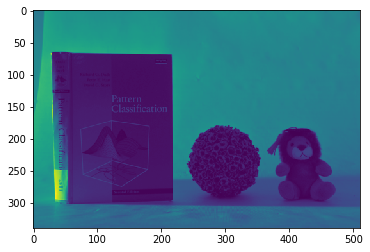

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import glob
import numpy as np

nonuni_pics = []
uni_pics = []

# read all scene folders
total_folers = glob.glob("../Phos2_0_2MP/Phos2_scene*")

# check out how many folders are there
print("Total number of scenes is: \t \t", len(total_folers))

# read the image filenames according to the category (nonuniform and uniform)
for each_foler in total_folers:
    nonuni_path = os.path.join(each_foler, "*_nonuni_*.png")
    uni_path = os.path.join(each_foler, "*_uni_*.png")
    nonuni_pics += glob.glob(nonuni_path)
    uni_pics += glob.glob(uni_path)

# check out dataset size
print("Number of non-uniform Pictures: \t", len(nonuni_pics))
print("Number of uniform Pictures: \t \t", len(uni_pics))

'''
set classifier as:
1   ->   non-uniform
0   ->   uniform
'''
nonuni_label = 1
uni_label = 0

# define the labels to the corresponding pictures
def DefineLabels(img_names, label):
    imgs = []
    labels = []
    for each_img_name in img_names:
        # read images as grayscale
        imgs.append(imread(each_img_name, as_gray = True))
        labels.append(label)
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels

nonuni_imgs, nonuni_labels = DefineLabels(nonuni_pics, nonuni_label)
uni_imgs, uni_labels = DefineLabels(uni_pics, uni_label)

# plot one of the images to check what the image looks like
plt.imshow(nonuni_imgs[0])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

'''
principle:
    60% selected as training dataset;
    20% selected as validation dataset;
    20% selected as test dataset.
'''
# shuffle images and labels at the same time
def ShuffleData(imgs, labels):
    index = np.arange(len(imgs))
    np.random.shuffle(index)
    return imgs[index], labels[index]

# first shuffle
nonuni_imgs, nonuni_labels = ShuffleData(nonuni_imgs, nonuni_labels)
uni_imgs, uni_labels = ShuffleData(uni_imgs, uni_labels)

# split the data into train, validation, test
def SplitData(imgs, labels, train_size, validation_size):
    X_train, X_rest, Y_train, Y_rest = train_test_split(imgs, labels, \
                                                        test_size = (1 - train_size), random_state=42)
    X_validation, X_test, Y_validation, Y_test = train_test_split(X_rest, Y_rest, \
                                                          test_size = (1 - validation_size), random_state=42)
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

# split nonuniform images and labels into 3 sets
nonuni_Xtrain, nonuni_Xvalidation, nonuni_Xtest, nonuni_Ytrain, nonuni_Yvalidation, nonuni_Ytest = \
                                            SplitData(nonuni_imgs, nonuni_labels, 0.6, 0.5)

uni_Xtrain, uni_Xvalidation, uni_Xtest, uni_Ytrain, uni_Yvalidation, uni_Ytest = \
                                            SplitData(uni_imgs, uni_labels, 0.6, 0.5)

# combine all images and labels into one set and shuffle it
def CombineDataAndShuffle(pre_combined_imgs, pre_combined_labels):
    # combine data
    combined_imgs = np.concatenate(pre_combined_imgs, axis = 0)
    combined_labels = np.concatenate(pre_combined_labels, axis = 0)
    # shuffle
    shuffled_imgs, shuffled_labels = ShuffleData(combined_imgs, combined_labels)
    return shuffled_imgs, shuffled_labels

# get pre-combined imgs and labels
X_train_pre, Y_train_pre = [nonuni_Xtrain, uni_Xtrain], [nonuni_Ytrain, uni_Ytrain]
X_validation_pre, Y_validation_pre = [nonuni_Xvalidation, uni_Xvalidation], [nonuni_Yvalidation, uni_Yvalidation]
X_test, Y_test = [nonuni_Xtest, uni_Xtest], [nonuni_Ytest, uni_Ytest]

# second shuffle
X_train, Y_train = CombineDataAndShuffle(X_train_pre, Y_train_pre)
X_validation, Y_validation = CombineDataAndShuffle(X_validation_pre, Y_validation_pre)
X_test, Y_test = CombineDataAndShuffle(X_test, Y_test)

print("Number of data used for training: \t", len(Y_train))
print("Number of data used for validation: \t", len(Y_validation))
print("Number of data used for test: \t \t", len(Y_test))


Number of data used for training: 	 135
Number of data used for validation: 	 45
Number of data used for test: 	 	 45


Validation score: 	 0.8888888888888888
Confusion Matrix: 
 [[27  0]
 [ 1 17]]
Accuracy: 		 0.9777777777777777
Recall: 		 1.0
Precision: 		 0.9444444444444444


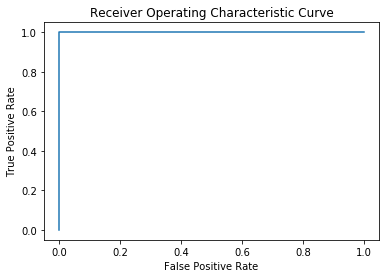

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve

def change_format(data):
    shape = data.shape
    return data.reshape((shape[0], -1))

X_train = change_format(X_train)
X_validation = change_format(X_validation)
X_test = change_format(X_test)

# all parameters not specified are set to their defaults
logistic_regression = LogisticRegression(solver = 'liblinear')

# fit data into model
logistic_regression.fit(X_train, Y_train)

# find out score
score = logistic_regression.score(X_validation, Y_validation)
print("Validation score: \t", score)

# predict labels
Pred_test = logistic_regression.predict(X_test)
Y_score = logistic_regression.decision_function(X_test)

# confusion matrix
confusionmatrix = confusion_matrix(Y_test, Pred_test)

# accuracy
accuracy = accuracy_score(Pred_test, Y_test)

# recall
recall = recall_score(Pred_test, Y_test)

# precision
precision = precision_score(Pred_test, Y_test)

# ROC
fpr, tpr, _ = roc_curve(Y_test, Y_score)

print("Confusion Matrix: \n", confusionmatrix)
print("Accuracy: \t\t", accuracy)
print("Recall: \t\t", recall)
print("Precision: \t\t", precision)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.show()


Total images: 	 	 	 225
Underexposed images: 	 	 60
Overexposed images: 	 	 60
Regular images: 	 	 105


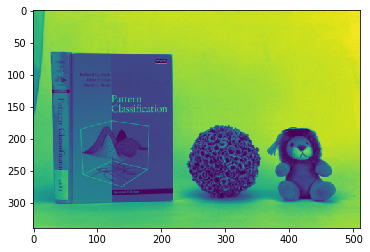

In [7]:
all_img = []
under_exp_img = []
over_exp_img = []

# read the image filenames according to the classes
for each_foler in total_folers:
    all_path = os.path.join(each_foler, "*.png")
    under_path = os.path.join(each_foler, "*_minus_*.png")
    over_path = os.path.join(each_foler, "*_plus_*.png")
    all_img += glob.glob(all_path)
    under_exp_img += glob.glob(under_path)
    over_exp_img += glob.glob(over_path)

# check the total number of images for further checkout
print("Total images: \t \t \t", len(all_img))

# initial regular images
regular_img = all_img

# remove all images shown in under exposed images
for img_i in under_exp_img:
    regular_img.remove(img_i)

# remove all images shown in over exposed images
for img_j in over_exp_img:
    regular_img.remove(img_j)
    
# check out dataset size
print("Underexposed images: \t \t", len(under_exp_img))
print("Overexposed images: \t \t", len(over_exp_img))
print("Regular images: \t \t", len(regular_img))

# set labels
'''
set classifier as:
0   ->   underexposed
1   ->   overexposed
2   ->   regular
'''
under_label = 0
over_label = 1
regular_label = 2

# define the labels to the corresponding pictures
underexp_imgs, underexp_labels = DefineLabels(under_exp_img, under_label)
overexp_imgs, ovexp_labels = DefineLabels(over_exp_img, over_label)
regular_imgs, regular_labels = DefineLabels(regular_img, regular_label)

# plot one of the images to check what the image looks like
plt.imshow(underexp_imgs[0])
plt.show()


In [15]:
# first shuffle
underexp_imgs, underexp_labels = ShuffleData(underexp_imgs, underexp_labels)
overexp_imgs, ovexp_labels = ShuffleData(overexp_imgs, ovexp_labels)
regular_imgs, regular_labels = ShuffleData(regular_imgs, regular_labels)

# split images and labels into 3 sets
under_Xtrain, under_Xvalidation, under_Xtest, under_Ytrain, under_Yvalidation, under_Ytest = \
                                            SplitData(underexp_imgs, underexp_labels, 0.6, 0.5)

over_Xtrain, over_Xvalidation, over_Xtest, over_Ytrain, over_Yvalidation, over_Ytest = \
                                            SplitData(overexp_imgs, ovexp_labels, 0.6, 0.5)

regular_Xtrain, regular_Xvalidation, regular_Xtest, regular_Ytrain, regular_Yvalidation, regular_Ytest = \
                                            SplitData(regular_imgs, regular_labels, 0.6, 0.5)

# get pre-combined imgs and labels
X_train_pre, Y_train_pre = [under_Xtrain, over_Xtrain, regular_Xtrain], [under_Ytrain, over_Ytrain, regular_Ytrain]
X_validation_pre, Y_validation_pre = [under_Xvalidation, over_Xvalidation, regular_Xvalidation], \
                                    [under_Yvalidation, over_Yvalidation, regular_Yvalidation]
X_test, Y_test = [under_Xtest, over_Xtest, regular_Xtest], [under_Ytest, over_Ytest, regular_Ytest]

# second shuffle
X_train, Y_train = CombineDataAndShuffle(X_train_pre, Y_train_pre)
X_validation, Y_validation = CombineDataAndShuffle(X_validation_pre, Y_validation_pre)
X_test, Y_test = CombineDataAndShuffle(X_test, Y_test)

# change image from (N, w, h) to (N, -1)
X_train = change_format(X_train)
X_validation = change_format(X_validation)
X_test = change_format(X_test)

"""
Same package used for "Binary Classifier"
"""
# all parameters not specified are set to their defaults
logistic_regression = LogisticRegression(solver='liblinear', multi_class='ovr')

# fit data into model
logistic_regression.fit(X_train, Y_train)

# find out score
score = logistic_regression.score(X_validation, Y_validation)
print("Validation score: \t", score)

# predict labels
Pred_test = logistic_regression.predict(X_test)

# confusion matrix
confusionmatrix = confusion_matrix(Y_test, Pred_test)

# accuracy
accuracy = accuracy_score(Pred_test, Y_test)

print("Confusion Matrix: \n", confusionmatrix)
print("Accuracy: \t\t", accuracy)


Validation score: 	 0.8666666666666667
Confusion Matrix: 
 [[ 8  0  4]
 [ 0 11  1]
 [ 3  1 17]]
Accuracy: 		 0.8
